<a href="https://colab.research.google.com/github/cdcmx2020a/group_a_twitter/blob/master/lesson3_twitter_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas unidecode wordcloud sklearn nltk tqdm gensim annoy

     |████████████████████████████████| 245kB 4.7MB/s 
     |████████████████████████████████| 645kB 36.3MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297332 sha256=fe066228631a2ced053ca9d7308acd9b16e751eb40c4f21c0ce36d48885f1709
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# progress bars 
from tqdm.notebook import tqdm
tqdm.pandas()

# text manipulation
from unidecode import unidecode
import re
import string
import nltk
nltk.download('punkt')

# gensim - for training embedding models
import gensim
import gensim.similarities.index
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# topic modeling, etc
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
def get_cases_df():
    df = pd.read_csv(
        'https://raw.githubusercontent.com/cdcmx2020a/group_a_twitter/master/covid_data/cases_mexico_transformed.csv'
    )
    df = df[['date', 'cases']].groupby('date', as_index=False)['cases'].sum()
    return df 


def get_news_df(lang):
    #lang options are 'en' or 'es'
    def _xform_text(x):
        if x != x:
            return ''
        else:
            return unidecode(str(x).strip('"'))
    manifest = pd.read_csv(
        f'https://raw.githubusercontent.com/cdcmx2020a/group_a_twitter/master/gnews_raw_{lang}/manifest.txt',
        header=None,
        names=['jsons'])['jsons'].tolist()
    dfs = []
    for f in tqdm(manifest):
        if 'manifest' in f:
            continue
        try:
            df = pd.read_csv(f'https://github.com/cdcmx2020a/group_a_twitter/blob/master/gnews_raw_{lang}/{f}?raw=true', names=['full_text'])
        except:
            continue 
        date = int(f.split('.')[0])
        df['date'] = date * np.ones(df.shape[0], dtype=int)
        df['full_text'] = df['full_text'].apply(_xform_text)
        dfs.append(df)
    df = pd.concat(dfs, axis=0) 
    return df 


def get_twitter_df():
    manifest = pd.read_csv(
        'https://raw.githubusercontent.com/cdcmx2020a/group_a_twitter/master/processed_json/manifest.txt',
        header=None,
        names=['jsons'])['jsons'].tolist()
    df = pd.concat(
        [pd.read_json(f'https://github.com/cdcmx2020a/group_a_twitter/blob/master/processed_json/{f}?raw=true', lines=True) 
            for f in tqdm(manifest)],
        axis=0
    )
    # df = df.query('date > 60')
    return df 


def reweight_twitter(df):
    n_days = {
        1: 31, 2: 29, 3: 31, 4: 30, 5: 31, 6: 30, 7:31
    }
    n_tweets = {
        1: 1.2e7, 2: 3.2e7, 3:4.0e7, 4: 3.1e7, 5: 3.2e7,
        6: 1.12e8, 7: 7.1e7 
    }
    month_weights = {'date':[], 'weight': [], 'ones': []}
    last = -1
    for m,days in tqdm(list(n_days.items())):
        start = last + 1 
        end = last + days 
        # print(m, start, end)
        last = end 
        n_recorded = df.query(f'date>={start} & date<={end}').shape[0]
        if n_recorded == 0:
            weight = 1
        else:
            weight = n_tweets[m] / n_recorded 
            # weight = int(1e6) / n_recorded
        month_weights['date'] += list(range(start, end+1))
        month_weights['weight'] += [weight] * days 
        month_weights['ones'] += [1] * days 
    
    df_weights = pd.DataFrame(month_weights)
    
    if 'weight' in df.columns:
        df = df.drop(columns=['weight', 'ones'])
    df_weighted = df.merge(df_weights, on='date', how='inner').sort_values(by='date')

    df_weighted = df_weighted.drop_duplicates(['full_text', 'date'], keep='first')

    return df_weighted


def get_stopword_list(lang):
    # lang options are 'english' or 'spanish'
    df = pd.read_csv(f'https://raw.githubusercontent.com/Alir3z4/stop-words/master/{lang}.txt', names='a')
    return df['a'].tolist()

In [4]:
tweets = get_twitter_df().query('lang == "en"')
display(tweets.head(1))

2020-08-11 14:17:05,823 : INFO : NumExpr defaulting to 2 threads.


,full_text,lat,lon,date,hashtags,place_type,place_name,country,favorites,retweets,lang
0,RT @ohboywhatashot: Moscow Airport.\n\nNow you...,NaN,NaN,62,[CoronaVirus],None,None,None,0,728,en


In [5]:
# remove punctuation and split sentences into words
# we write directly to disk to avoid running out of RAM
fbuffer = open('buffer.txt', 'w')
fbuffer.write('\n'.join(tweets['full_text'].progress_apply(
        lambda s: s.translate(str.maketrans('', '', string.punctuation))
    ).tolist()))
fbuffer.close()

# the below is a better tokenization, but substantially slower. the above method takes
# 1-2m on the English tweet dataset; 20m for nltk tokenization
# tokenized_tweets = tweets['full_text'].progress_apply(nltk.word_tokenize).tolist()

## Neural networks

This is a very very very quick introduction to NNs and how to train them, just so we can proceed with the discussion. For further reading, you can get started [here](https://cs231n.github.io/neural-networks-1/) and [here](https://cs231n.github.io/optimization-2/). And of course, ask questions on Slack :)

A feed-forward neural network is two things: matrix multiplications and simple non-linear functions. What does that mean? Let's say I have an input vector $x_i$ of dimension $d_i$.

### Matrix multiplication

This step is how we change the size of the data. Because a matrix multiplication is a linear transfomration, we can think of this as the linear part of the NN. We define a matrix $W_{j}$:

$$W_{j}, \text{ of size }d_i \times d_j $$

Then, the linear transformation is just multiplication:

$$W_{j} x_i$$

### Non-linearity

Generally, linear transformations of the data are not expressive enough. Even multiple linear transformations doesn't help (why?). So, we introduce non-linear functions:

![act fns](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1547672259/4_jouacz.png)

### Feed-forward layer

The composition of a linearity and non-linearity is what we usually call a "layer":

$$ x_j = \sigma(W_{j}x_i)$$ 

Because $x_j$ is also a vector (of size $d_j$), we can easily stack multiple layers, creating a feed-forward NN.

![nns](https://static.packt-cdn.com/products/9781788397872/graphics/1ebc2a0a-2123-4351-b7e1-eb57f098bafa.png)

## Training a neural network

"Training" means finding the values of parameters (e.g. $W_j$) to optimize the output of the NN for some task. This is typically accomplished by showing the NN examples of correct inputs and outputs. I'm not going to dig into the details of how this is done, in the interest of time. If you are interested, we can dedicate a whole class to this later in the week - I'll send a poll. In the meantime, take a look [here](https://cs231n.github.io/optimization-2/).


## Word embeddings

We've talked about a few ways of representing words and documents numerically: bag-of-words, tf-idf, NMF. All of these methods have some drawbacks:

    - Lack of context, except through n-grams
    - "Distance" in representation space is not well-defined

We want to find a representation (or embedding) that will produce things like this:
![From Mikolov2013](https://pathmind.com/images/wiki/countries_capitals.png)

A key advancement in natural language processing was the invention of Word2Vec [[Mikolov2013](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf), [blog post](https://jalammar.github.io/illustrated-word2vec/)]. The concept is simple: the definition of a word is largely determined by the other words that appear near it:
```
The capital of Canada is <Ottawa>.
Prime Minister Trudeau spoke in <Ottawa> today.
<Ottawa>'s population is 930,000
```

So, let's train a neural network to solve this task:

![](https://pvsmt99345.i.lithium.com/t5/image/serverpage/image-id/45458iDEB69E518EBA3AD9/image-size/large?v=1.0&px=999)

Each word corresponds to a single column in the weight matrix. This is the "embedding" of the word.

![](https://miro.medium.com/max/1000/1*1O5gLhOg25HviI8bwZxV4g.png)



In [6]:
print('Training Word2Vec model!')
# build and train model
w2v = gensim.models.Word2Vec(
    corpus_file='buffer.txt',
    min_count=100,  # ignore words that appear fewer than 100x. this is aggressive
    size=32,        # embedding dimension. this is a bit smaller
    workers=2,      # use 2 CPUs to train,
    sg=0,           # use CBOW for speed, but skip-gram is bit better for small datasets
    iter=1,         # number of times to train on the data. typically want >1
)
w2v.delete_temporary_training_data()

2020-08-11 14:19:05,278 : INFO : collecting all words and their counts
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-08-11 14:19:05,281 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-11 14:19:05,360 : INFO : PROGRESS: at sentence #10000, processed 142921 words, keeping 25678 word types
2020-08-11 14:19:05,439 : INFO : PROGRESS: at sentence #20000, processed 285132 words, keeping 40446 word types
2020-08-11 14:19:05,520 : INFO : PROGRESS: at sentence #30000, processed 425399 words, keeping 52320 word types


Training Word2Vec model!


2020-08-11 14:19:05,602 : INFO : PROGRESS: at sentence #40000, processed 568314 words, keeping 63235 word types
2020-08-11 14:19:05,695 : INFO : PROGRESS: at sentence #50000, processed 709170 words, keeping 73149 word types
2020-08-11 14:19:05,783 : INFO : PROGRESS: at sentence #60000, processed 850768 words, keeping 82652 word types
2020-08-11 14:19:05,867 : INFO : PROGRESS: at sentence #70000, processed 990436 words, keeping 91625 word types
2020-08-11 14:19:05,957 : INFO : PROGRESS: at sentence #80000, processed 1132063 words, keeping 100103 word types
2020-08-11 14:19:06,045 : INFO : PROGRESS: at sentence #90000, processed 1272885 words, keeping 108229 word types
2020-08-11 14:19:06,135 : INFO : PROGRESS: at sentence #100000, processed 1413692 words, keeping 115891 word types
2020-08-11 14:19:06,216 : INFO : PROGRESS: at sentence #110000, processed 1553218 words, keeping 123434 word types
2020-08-11 14:19:06,303 : INFO : PROGRESS: at sentence #120000, processed 1695310 words, keepi

In [7]:
# map vectors to two dimensions using a PCA
pca = PCA(2).fit(w2v.wv.vectors)

# build an index for fast search
w2v_index = gensim.similarities.index.AnnoyIndexer(model=w2v, num_trees=32)

2020-08-11 14:22:57,614 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/similarities/index.py:180: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)


### Embedding distances

We want a distance metric $d(u,v)$ between embeddings $u$ and $v$.

What properties should $d$ have?




Euclidean distance:
$$
d(u,v) = \sqrt{\sum_{i=1}^d (u_i - v_i)^2}
$$

Cosine distance:
$$
d(u,v) = 1 - \frac{u\cdot v}{||u||\cdot ||v|}
$$

![](https://f-origin.hypotheses.org/wp-content/blogs.dir/4190/files/2018/04/3dplot-500x381.jpg)


In [8]:
# nearest-vector lookup
def get_nearest(word, model, index):
    # look up the vector of the given word
    vec = model.wv[word]
    # find the other words that have the highest cosine similarity
    nbors = [x[0] for x in model.wv.most_similar([vec], topn=11, indexer=index)]
    # for convenience, we also check the vectors for those words
    vecs = [model.wv[n] for n in nbors]
    return nbors, vecs, vec

['coronavirus', 'COVID19', 'Covid19', 'covid19', 'coronavirus…', 'COVID', 'Covid', 'covid', 'coronavi…', 'cor…', 'coronav…']
['pandemic', 'pandemic…', 'pa…', 'pande…', 'pan…', 'pand…', 'pandemi…', 'pandem…', 'epidemic', 'lockdow…', 'global']
['n95', 'homemade', 'N95', 'wearers', 'reusable', 'goggles', 'respirator', 'reuse', 'sunglasses', 'surgical', 'fitted']
['RT', 'SethAbramson', 'derekjames150', 'Horrifying', 'ChelseaClinton', 'jefftimmer', 'ChrisMurphyCT', 'LaurieGarrett', 'ElieNYC', 'OhNoSheTwitnt', 'MLevittNP2013']


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` i

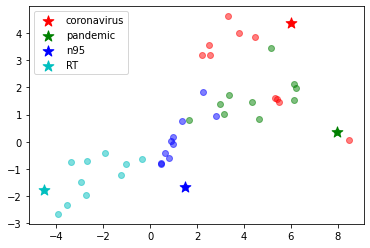

In [11]:
for term, color in zip(('coronavirus', 'pandemic', 'n95', 'RT'), ('r', 'g', 'b', 'c', 'm', 'y', 'k')):
    terms, vecs, vec = get_nearest(term, w2v, w2v_index)
    vecs = np.stack(vecs, axis=0)
    vecs = pca.transform(vecs)
    plt.scatter(vecs[:,0], vecs[:,1], alpha=0.5, c=color)
    vec = pca.transform(vec.reshape(1,-1)).flatten()
    plt.scatter(vec[0], vec[1], marker='*', s=128, c=color, label=term)
    print(terms)
plt.legend()
plt.show()

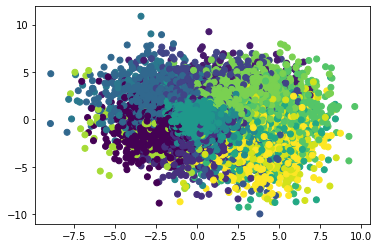

In [24]:
# build an agglomerative clustering model
# cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='cosine', linkage='average')
# actually, let's see how bad k-means with Euclidean distance is
k = 16
cluster = KMeans(k)
# fit to the embedding vectors
labels = cluster.fit_predict(w2v.wv.vectors)
vectors_2d = pca.transform(w2v.wv.vectors)
plt.scatter(vectors_2d[:,0], vectors_2d[:,1], c=labels)
plt.show()

In [26]:
distances = cluster.transform(w2v.wv.vectors)
vocab = list(w2v.wv.vocab.keys())
for i in range(k):
    closest = np.argsort(distances[:,i])[:10]
    msg = f'Cluster {i}: '
    msg += ', '.join([vocab[j] for j in closest])
    print(msg)


Cluster 0: Ardern, krystalball, grandmas, norm, Fear, SocialDistance, Yemen, Apologies, HANKS, Russia…
Cluster 1: snakes, 25th, bueti, NancyPelosi, operation, reactive, landed, revenge, Democracy, Lou16em
Cluster 2: DrJoeAbah, wishlist, Responding, EdanClay, JoaquinCastrotx, thousa…, TraitorTrump, smallbusiness, ₹, Teresa
Cluster 3: Streaming, Down, utmost, undoubtedly, Policy, farm, way…, CLEAN, uncertainties, Rachel
Cluster 4: distributed, photograph, PhD, explore, breath…, TheStalwart, willing, enables, gover…, DR
Cluster 5: Pete, RepJoeKennedy, Las, VitalVegas, Uh, poses, examples, convince, life…, TrumperSeaney
Cluster 6: Graves, Hmm, earthshakerph, hunch, Unlike, 27000, dereliction, refuse, pleaded, pointed
Cluster 7: home’, Bodies, rider, smartdissent, IndianMuslimahs, coolest, nobid, elemental, jpbrammer, Statues
Cluster 8: contradict, outright, merch, Ironhorse76, AAIOfficial, A2, shiny, reopeni…, lunatics, Masvidal
Cluster 9: redheart…, secret, uplifting, illustrated, facewit

## Fast document search

Let's build a system to quickly search for similar tweets. 

We can take the same approach: represent each tweet as a vector. But how?

![](https://i.stack.imgur.com/t7slV.png)

In [ ]:
d2v = gensim.models.doc2vec.Doc2Vec(
    corpus_file='buffer.txt',
    epochs=1,
    min_count=100,
    vector_size=32,
    workers=2,
    dm=0
)

In [12]:
vec = d2v.infer_vector('When is this pandemic going to end?')
similar = d2v.docvecs.most_similar([vec], topn=10)